# Assignment 2

Name: Ben McLennan

Student Number: 218737145

## Task 1.1: Define the Problem

This problem will involve image classification in order to differentiate between the different recyclable materials and those which are not. I think the most effective way to go about this will be to have target classes for all of the recyclable materials, and one 'umbrella' class to encompass all non-recyclable materials. After some experimentation, it may be found that having target classes for the non-recyclable materials is more effective, but there is only one way to find out.

So, the inputs for this task will be images of recyclable items and non-recyclable rubbish, and the outputs will be one of the following classes: **paper**, **aluminium and steel**, **cardboard**, **hard plastic**, **glass**, **non-recyclable**.

Of course, if the image falls in any category other than **non-recyclable**, will result in it being recyclable.

## Task 1.2: Make a Plan

The first step is to find an appropriate dataset for the task, containing images of recycling and garbage that are labelled correctly. There are abundant resources for this task, but the most appropriate dataset I have found is found on Kaggle and created by CCHANGCS:

https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

This dataset contains nearly exactly the classes I require, those being cardboard, glass, paper, metal, plastic and trash, and are all labelled as such. There is a problem however, as this dataset only contains approximately 2500 images; I will address this problem through transfer learning. I will use 85% and 15% for training and testing respectively.

For the final testing of the model, I will be ecstatic if I can get 90% accuracy, however anything above 80% will be considered a win.

## Task 1.3: Implement a Solution

### Importing and visualising the data

The first step is to import the data:

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython.display
import PIL.Image
import sklearn.model_selection
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#[1] CCHANGCS, Garbage Classification, Kaggle: 
#<https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification?resource=download>

# [2] Tensorflow, Tensorflow Documentation https://www.tensorflow.org/tutorials/load_data/images
# directory = "C:\\Users\\61429\\Desktop\\UNI\\DEEPLEARNING\\Ass2\\Data\\Garbage classification\\Garbage classification"

# data = tf.keras.preprocessing.image_dataset_from_directory(directory)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
directory = "/content/drive/MyDrive/Garbage classification"

data = tf.keras.preprocessing.image_dataset_from_directory(directory)

Found 2527 files belonging to 6 classes.


In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
classes = data.class_names
print(classes)

for image, label in data:
    print(image.shape)
    break

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
(32, 256, 256, 3)


Above we have the classes and the shape of the images, which we will require later on.

Now that the data is imported, let's take a look at an example of each class:

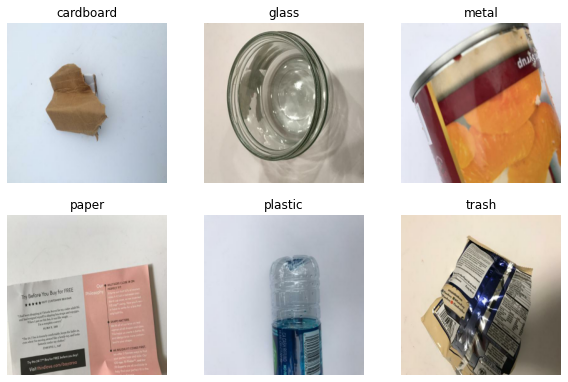

In [8]:
#[3] Code snippet by Harsha AS, May 2021
#<https://stackoverflow.com/questions/66302994/get-a-sample-of-one-image-per-class-with-image-dataset-from-directory>

plt.figure(figsize=(10, 10))
for i in range(len(classes)):
    filtered = data.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(classes[label.numpy()[0]])
        plt.axis('off')

As stated above, due to the small number of examples, I will be using transfer learning. I have chosen the VGG16 ImageNet. ImageNet requires images of size (150, 150, 3), so we need to get the images to this size first.

### Building the Model

Since the task is image recognition, a convolutional network is the most appealing layering to use. First, we need to split the data into training and testing sets and normalize them.

In [22]:
#[4] https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.15)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15)

train_generator = train_datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=64,
        color_mode = 'rgb',
        class_mode='categorical',
        subset = 'training')

validation_generator = test_datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=64,
        color_mode = 'rgb',
        class_mode='categorical', 
        subset = 'validation')

Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [23]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()
conv_base.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [24]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.4))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(lr=.00005),#.001
                loss='categorical_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [25]:
history = model.fit_generator(
      train_generator,
      epochs=30,
      validation_data=validation_generator
      )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/30
34/34 [==============================] - 17s 459ms/step - loss: 1.7352 - accuracy: 0.3940 - val_loss: 1.6551 - val_accuracy: 0.3528
Epoch 2/30
34/34 [==============================] - 15s 442ms/step - loss: 1.1353 - accuracy: 0.5805 - val_loss: 1.4703 - val_accuracy: 0.3926
Epoch 3/30
34/34 [==============================] - 16s 456ms/step - loss: 0.9060 - accuracy: 0.6744 - val_loss: 1.2730 - val_accuracy: 0.4907
Epoch 4/30
34/34 [==============================] - 15s 436ms/step - loss: 0.7319 - accuracy: 0.7316 - val_loss: 1.1528 - val_accuracy: 0.5650
Epoch 5/30
34/34 [==============================] - 15s 440ms/step - loss: 0.6511 - accuracy: 0.7591 - val_loss: 0.9834 - val_accuracy: 0.6578
Epoch 6/30
34/34 [==============================] - 16s 479ms/step - loss: 0.5549 - accuracy: 0.8047 - val_loss: 0.9185 - val_accuracy: 0.6870
Epoch 7/30
34/34 [==============================] - 15s 440ms/step - loss: 0.4740 - accuracy: 0.8433 - val_loss: 0.8509 - val_accuracy: 0.7003

Strangely, even when the loss decreases, the validation accuracy doesn't necessarily increase. In a similar vein, even with an extremely high training accuracy, the validation accuracy doesn't increase beyond 75%. This could be because a number of images are still unknown and are being assigned 'random' labels, or it could simply be that the model is overfitting - the latter seems more likely.

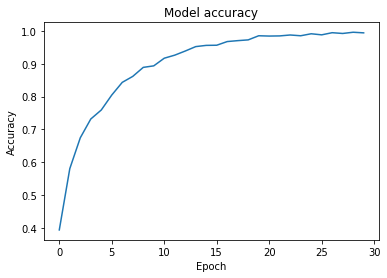

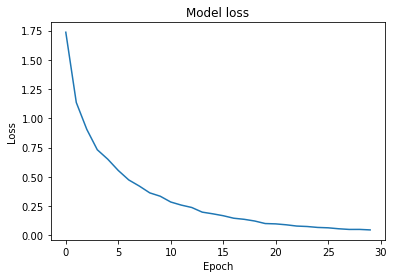

In [26]:
import matplotlib.pyplot as plt

# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot training loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

By the looks of the graphs, the effectiveness of the model stops at this validation
 accuracy of around 75%, after which the accuracy and loss both fluctuate. Increasing the number of epochs will not help. 

The difference between testing and validation accuracy is likely due to the small size of the dataset.

Unfortunately, I have not been able to reach the 80-90% accuracy I aimed for this way. Let's try fine-tuning the layers in block 5 that connect to the dense head. In order to address the overfitting above, I will increase the rate of the dropout layer and run for less epochs.

In [57]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()
conv_base.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [58]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [59]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.15)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15)

train_generator = train_datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=64,
        color_mode = 'rgb',
        class_mode='categorical',
        subset = 'training')

validation_generator = test_datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=64,
        color_mode = 'rgb',
        class_mode='categorical', 
        subset = 'validation')

Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [60]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.8))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(lr=.00005),#.001
                loss='categorical_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [61]:
history = model.fit_generator(
      train_generator,
      epochs=20,
      validation_data=validation_generator
      )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/20
34/34 [==============================] - 18s 494ms/step - loss: 2.5235 - accuracy: 0.3595 - val_loss: 1.3752 - val_accuracy: 0.4960
Epoch 2/20
34/34 [==============================] - 17s 483ms/step - loss: 1.6799 - accuracy: 0.5000 - val_loss: 1.0837 - val_accuracy: 0.6233
Epoch 3/20
34/34 [==============================] - 16s 471ms/step - loss: 1.2692 - accuracy: 0.5953 - val_loss: 0.9352 - val_accuracy: 0.6737
Epoch 4/20
34/34 [==============================] - 16s 470ms/step - loss: 0.9916 - accuracy: 0.6833 - val_loss: 0.8398 - val_accuracy: 0.7056
Epoch 5/20
34/34 [==============================] - 16s 472ms/step - loss: 0.7538 - accuracy: 0.7498 - val_loss: 0.8857 - val_accuracy: 0.6923
Epoch 6/20
34/34 [==============================] - 16s 474ms/step - loss: 0.6791 - accuracy: 0.7726 - val_loss: 0.7688 - val_accuracy: 0.7268
Epoch 7/20
34/34 [==============================] - 16s 472ms/step - loss: 0.5238 - accuracy: 0.8186 - val_loss: 0.7391 - val_accuracy: 0.7347

While this was better, the model is still overfitting; I believe that the small size of the dataset is one of the big issues here. The next logical step is to include Data Augmentation to increase the size of the data. This step will be included in a pipeline. I will address the potential augmentations and their relevance here:

Rotating and flipping the images will be beneficial to the model as the model may see the items from any angle.

Shifting horizontally and vertically will be beneficial as it will potentially help the model recognise distinct features of each class; this could have the opposite effect though, where the distinctions are instead cut out by the shift. This augmentation will need to make only a slight change or it could throw the model off.

Zoom and shear will be beneficial again to give the model different angles and shapes of the potential data.

So, time to test the model with these included. Now that the training set is effectively larger, the number of epochs can be increased again.

In [73]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()
conv_base.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [74]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [75]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip=True,
    validation_split = 0.15)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15)

train_generator = train_datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical', 
        subset = 'training')

validation_generator = test_datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical', 
        subset = 'validation')

Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [76]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.8))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(lr=.00005),#.001
                loss='categorical_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [77]:
history = model.fit_generator(
      train_generator,
      epochs=30,
      validation_data=validation_generator
      )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/30
34/34 [==============================] - 33s 849ms/step - loss: 2.6102 - accuracy: 0.3237 - val_loss: 1.4650 - val_accuracy: 0.3926
Epoch 2/30
34/34 [==============================] - 27s 782ms/step - loss: 1.9448 - accuracy: 0.4581 - val_loss: 1.3252 - val_accuracy: 0.4642
Epoch 3/30
34/34 [==============================] - 28s 811ms/step - loss: 1.6704 - accuracy: 0.4981 - val_loss: 1.2294 - val_accuracy: 0.4881
Epoch 4/30
34/34 [==============================] - 27s 790ms/step - loss: 1.4357 - accuracy: 0.5553 - val_loss: 1.0746 - val_accuracy: 0.5729
Epoch 5/30
34/34 [==============================] - 29s 835ms/step - loss: 1.3037 - accuracy: 0.6163 - val_loss: 1.0648 - val_accuracy: 0.5836
Epoch 6/30
34/34 [==============================] - 28s 810ms/step - loss: 1.1917 - accuracy: 0.6260 - val_loss: 1.0264 - val_accuracy: 0.5703
Epoch 7/30
34/34 [==============================] - 27s 794ms/step - loss: 1.0328 - accuracy: 0.6688 - val_loss: 0.9163 - val_accuracy: 0.6631

81% accuracy. Now we're cooking with gas! Additionally, with these augmentations, the model doesn't appear to be overfitting as much, so it could be run for longer - with diminishing returns. The augmentations have resulted in a roughly 5% increase in validation accuracy and I have achieved the goal of 80%.

Each epoch ran for an extra 10 seconds, so overall this model ran for an extra 490 seconds - nearly 10 minutes longer. If it were to have ran for the same amount of time as the previous model, it only would've reached epoch 15, where the accuracy was still approximately 75%; I think this is a worthwhile time investment.

## Reflection

I think the biggest issue I had with this model was the size of the training set. Due to it being so small, the model overfit quickly and was unable to appropriately identify some of the key features. Additionally, the augmentations didn't have as large of an effect as I was expecting on the accuracy - some more fine tuning of the augmentations would be beneficial to the overall model.

Despite these issues, I am happy with the 81% accuracy.

## Reference List

[1] CCHANGCS, 2019, "Garbage Classification Dataset", [Online], Kaggle. Available: <https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification?resource=download>

[2] Tensorflow, "Load and Preprocess Images", [Documentation], updated 2022-01-26. Available: <https://www.tensorflow.org/tutorials/load_data/images>

[3] Harsha AS, May 2021, "Get a sample of one image per class with image_dataset_from_directory" [Online Forum Post]. StackOverflow. Available: <https://stackoverflow.com/questions/66302994/get-a-sample-of-one-image-per-class-with-image-dataset-from-directory>

[4] Tensorflow, "tf.keras.preprocessing.image.ImageDataGenerator", [Documentation], updated 2022-04-30. Available: <https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator>